In this tutorial we will build rules for fully actuated grippers

In [9]:
import numpy as np
import pychrono as chrono

from rostok.block_builder_api.block_blueprints import (PrimitiveBodyBlueprint,
                                                       RevolveJointBlueprint,
                                                       TransformBlueprint)
from rostok.block_builder_api.block_parameters import JointInputType
from rostok.block_builder_api.easy_body_shapes import Box
from rostok.block_builder_chrono.blocks_utils import FrameTransform
from rostok.graph_grammar import rule_vocabulary
from rostok.graph_grammar.node import ROOT
from rostok.graph_grammar.node_vocabulary import NodeVocabulary
from rostok.utils.dataset_materials.material_dataclass_manipulating import (
    DefaultChronoMaterialNSC, DefaultChronoMaterialSMC)

At first we create auxiliary functions.

In [10]:
def get_density_box(mass: float, box: Box):
    volume = box.height_z * box.length_y * box.width_x
    return mass / volume

def rotation_y(alpha):
    quat_Y_ang_alpha = chrono.Q_from_AngY(np.deg2rad(alpha))
    return [quat_Y_ang_alpha.e0, quat_Y_ang_alpha.e1, quat_Y_ang_alpha.e2, quat_Y_ang_alpha.e3]

def rotation_z(alpha):
    quat_Z_ang_alpha = chrono.Q_from_AngZ(np.deg2rad(alpha))
    return [quat_Z_ang_alpha.e0, quat_Z_ang_alpha.e1, quat_Z_ang_alpha.e2, quat_Z_ang_alpha.e3]

Create `NodeVocabulary` and all non-terminal nodes. Here non-terminal nodes are abstract blocks as Transforms, links and joints. Also there are special nodes that represents the points that can be used to grow the graph. 

In [11]:
# Nodes
node_vocab = NodeVocabulary()
node_vocab.add_node(ROOT)
node_vocab.create_node(label="F") # base node for a finger
node_vocab.create_node(label="RF") # base node for a reversed finger


node_vocab.create_node(label="FG") # node that represents a point of finger grow
node_vocab.create_node(label="L") # abstract link

node_vocab.create_node(label="TP") # abstract positive transform node without particular value
node_vocab.create_node(label="TN") # abstract negative transform node without particular value
node_vocab.create_node(label="RT") # reverse of a finger

Next step is to create descriptions for all physical blocks.  
At first we create description for bodies

In [12]:
def_mat = DefaultChronoMaterialNSC()
# blueprint for the palm
super_flat = PrimitiveBodyBlueprint(
    Box(0.3, 0.01, 0.30), material=def_mat, color=[255, 0, 0])
# blueprint for the base
base = PrimitiveBodyBlueprint(Box(0.03, 0.01, 0.03),
                                material=def_mat,
                                color=[0, 120, 255],
                                density=10000)

# sets effective density for the links, the real links are considered to be extendable.
link_mass = (28 + 1.62 + 2.77) * 1e-3
length_link = [0.05, 0.06, 0.075]
# create link blueprints using mass and length parameters
link = list(
    map(
        lambda x: PrimitiveBodyBlueprint(Box(0.035, x, 0.027),
                                            material=def_mat,
                                            color=[0, 120, 255],
                                            density=get_density_box(link_mass, Box(
                                                0.035, x, 0.027))), length_link))

And create the corresponding terminal nodes.

In [13]:
node_vocab.create_node(label="FT", is_terminal=True, block_blueprint=super_flat) # palm
node_vocab.create_node(label="B", is_terminal=True, block_blueprint=base)
node_vocab.create_node(label="L1", is_terminal=True,
                        block_blueprint=link[0])
node_vocab.create_node(label="L2", is_terminal=True,
                        block_blueprint=link[1])
node_vocab.create_node(label="L3", is_terminal=True,
                        block_blueprint=link[2])

Second set of physical descriptors are transformations

In [14]:
x_translation_values = [0.07, 0.107, 0.144]
X_TRANSLATIONS = list(
    map(lambda x: FrameTransform([x, 0, 0], [1, 0, 0, 0]), x_translation_values))

# rotation to 180 degrees around vertical axis
REVERSE_Y = FrameTransform([0, 0, 0], [0, 0, 1, 0])

# create transform blueprints from the values
x_translation_transform = list(
    map(lambda x: TransformBlueprint(x), X_TRANSLATIONS))


reverse_transform = TransformBlueprint(REVERSE_Y)


Create terminal nodes for transformations

In [15]:
node_vocab.create_node(label="RE", is_terminal=True,
                        block_blueprint=reverse_transform)

node_vocab.create_node(label="RT1",
                        is_terminal=True,
                        block_blueprint=x_translation_transform[0])
node_vocab.create_node(label="RT2",
                        is_terminal=True,
                        block_blueprint=x_translation_transform[1])
node_vocab.create_node(label="RT3",
                        is_terminal=True,
                        block_blueprint=x_translation_transform[2])

And finally describe the joint parameters. We don't need non-terminal nodes for joints because we only use one type of nodes.  

In [16]:
mass_joint = (10 / 3 + 0.51 * 2 + 0.64 + 1.3) * 1e-3  # 0.012
joint_radius_base = 0.015
joint_radius = 0.015
joint_length = 0.025
density_joint = (mass_joint / (0.03 * 3.14 * joint_radius**2))

revolve = RevolveJointBlueprint(JointInputType.TORQUE, material=def_mat, radius=joint_radius_base,
                                length=joint_length, density=density_joint, stiffness=0.0, damping=0)
revolve_base = RevolveJointBlueprint(JointInputType.TORQUE, material=def_mat, radius=joint_radius_base,
                                        length=joint_length, density=density_joint, stiffness=0.0, damping=0)

In [17]:
node_vocab.create_node(label="J", is_terminal=True, block_blueprint=revolve)
node_vocab.create_node(label="JB", is_terminal=True, block_blueprint=revolve_base)

Now we have all required nodes and can start build rules

In [18]:
rule_vocab = rule_vocabulary.RuleVocabulary(node_vocab)
rule_vocab.create_rule("Init", ["ROOT"], ["FT", "F", "RF"], 0, 0,
                        [(0, 1), (0, 2)])

rule_vocab.create_rule("AddFinger", ["F"], ["RT", "B", "JB", "L", "FG"], 0, 0, [(0, 1), (1, 2),
                                                                                (2, 3), (3, 4)])
rule_vocab.create_rule("RemoveFinger", ["F"], [], 0, 0, [])

rule_vocab.create_rule("AddFinger_R", ["RF"], ["RE", "RT", "B", "JB", "L", "FG"], 0, 0,
                        [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)])
rule_vocab.create_rule("RemoveFinger_R", ["RF"], [], 0, 0, [])

rule_vocab.create_rule("Terminal_Radial_Translate1",
                        ["RT"], ["RT1"], 0, 0, [])
rule_vocab.create_rule("Terminal_Radial_Translate2",
                        ["RT"], ["RT2"], 0, 0, [])
rule_vocab.create_rule("Terminal_Radial_Translate3",
                        ["RT"], ["RT3"], 0, 0, [])

rule_vocab.create_rule("Phalanx", ["FG"], [
                        "J", "L", "FG"], 0, 0, [(0, 1), (1, 2)])

rule_vocab.create_rule("Terminal_Link1", ["L"], ["L1"], 0, 0, [])
rule_vocab.create_rule("Terminal_Link2", ["L"], ["L2"], 0, 0, [])
rule_vocab.create_rule("Terminal_Link3", ["L"], ["L3"], 0, 0, [])
rule_vocab.create_rule("Remove_FG", ["FG"], [], 0, 0, [])

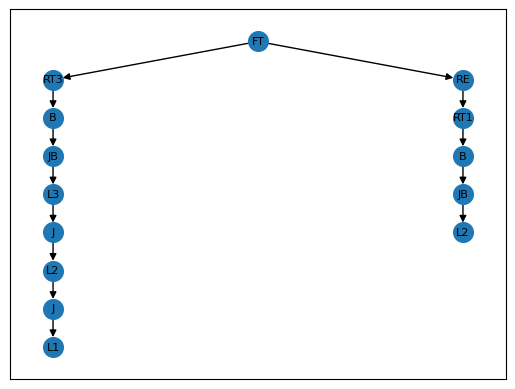

In [23]:
from rostok.graph_grammar.node import GraphGrammar
from rostok.graph_grammar.graph_utils import plot_graph
graph = GraphGrammar()
rules = ["Init",
    "AddFinger", "Terminal_Radial_Translate3",  "Phalanx", "Phalanx", "Remove_FG",
    "Terminal_Link3", "Terminal_Link2", "Terminal_Link1",
    "AddFinger_R", "Terminal_Radial_Translate1",  "Remove_FG", "Terminal_Link2",

]

for rule in rules:
    graph.apply_rule(rule_vocab.get_rule(rule))

plot_graph(graph)

